Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [98]:
from random import choices, seed, choices, random

import lab9_lib
import numpy as np
import copy
import matplotlib.pyplot as plt

In [84]:
fitness = lab9_lib.make_problem(2)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

11101001010111111001010110100100010001010001000001: 28.40%
10110111111100010110101011111111100110111101000010: 31.00%
01010001010101000101010111000110000100100000111101: 31.00%
01100011110110101001000000011110101111011011111101: 27.20%
01010110110100001100011011001001000011111111100101: 27.80%
11011101001011110000110000001110101001010010010110: 48.00%
11001101000110111010110010001010010100111011001000: 26.00%
11110111101100011010101001000111010000100011000101: 23.60%
00111010111100101000110100010001100100010100101001: 44.00%
00010101001010010111011111010010110010101010000100: 21.80%
10


# Ideas

## Tricks and ideas

- Save configurations + fitness in a dictionary to avoid repetitions
- Create a CNN+FC to, first extract the genome information (necessary spatial information) and then predict the associated fitness


## Island

- Generate K islands, evolve them independently and, each N mutations, let one individual from each travel to others (one individual can travel to multiple islands?). How to choose the individual?


## Mutation

- Change the bit with a given probability. How many bits to mutate?


## Save the best

- Elitism: copy the champion into the offsprings without modifications
- Valhalla: keep the best apart and, from time to time, put them back in the population


## Recombination

- Implement one cuts/two cuts/n cuts
- Do it choosing the idx through a Gaussian


## Parent selection (semi stochastic)

- Try roulette (linearized proportional to fitness, trouble with big populations)
- Try tournament (increase size to increase pressure)


## Survival selection (fully deterministic)

- Filter only the top K fittest individuals

# Our Solution

## V1.0

The simplest approach.

In [86]:
def mutate_bit(individual : list) -> list:
    
    idx = np.random.randint(0, len(individual))
    mutated_individual = copy.deepcopy(individual)
    mutated_individual[idx] = int(not(bool(mutated_individual[idx])))
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:

    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:

    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))

In [87]:
POP_SIZE = 100          # Number of parents
N_OFFSPRINGS = 300      # Number of children
N_GENERATIONS = 10000   # Number of generations
TOP_K = 30              # Number of parents from which generating the offsprings
SIZE = 30               # Size of the genome

pop = []
for _ in range(POP_SIZE):
    pop.append(choices([0, 1], k=SIZE))

In [88]:
parents = roulette_selection(TOP_K, pop, [fitness(ind) for ind in pop])

for _ in range(N_GENERATIONS):
        
    recombinated_offsprings = map(one_cut_xover, parents)
    mutated_offsprings = np.array(list(map(mutate_bit, recombinated_offsprings)))
    fit = np.array(list(map(fitness, mutated_offsprings)))
    survived = mutated_offsprings[np.argsort(fit) < POP_SIZE]
    if (fit > 0.95).any():
        break
    parents = roulette_selection(TOP_K, survived, [fitness(ind) for ind in survived])
    print(_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [92]:
mutated_fitness = list(map(fitness, mutated_offsprings))
ordered_mutated = [_ for _, x in sorted(zip(mutated_offsprings, mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")

111111111111111111111111111111: 100.00%
111011111101111111111111111111: 93.33%
101111011101111110111111111111: 86.67%
011111111111011011101111111111: 86.67%
111111111101111101101011111111: 86.67%
111111100101111111111111111110: 86.67%
001111111111111101101111111111: 86.67%
111111011001111111111111111110: 86.67%
101111111111011011011101111110: 80.00%
001111111111011111101111110110: 80.00%
101111111011011011111101111101: 80.00%
111111111100111101101101111011: 80.00%
111111111111011101101111001011: 80.00%
111111111101111111101101001011: 80.00%
101111111111011011110101100011: 73.33%
111011111101100111111101101100: 73.33%
101111111111011011111100001101: 73.33%
111111011111011011001100101111: 73.33%
111011111101101111011111000110: 73.33%
101101111111011011111100101101: 73.33%
111011111101111101101101001011: 73.33%
011010110101111011101101111111: 73.33%
101111111111011011111101100001: 73.33%
101111111101011011111101100011: 73.33%
101111011111011011111101101100: 73.33%
101111111111011011111101

## V1.5
Basic implementation of the Valhalla loading the champions at every epoch.

In [135]:
POP_SIZE = 100          # Number of parents
N_OFFSPRINGS = 300      # Number of children
N_GENERATIONS = 10000   # Number of generations
TOP_K = 30              # Number of parents from which generating the offsprings
EPOCH = 30              # Number of generation to reintroduce the best fitting
N_CHAMPIONS = 4         # Number of champions that will rest in the Valhalla
SIZE = 50               # Size of the genome


pop = []
for _ in range(POP_SIZE):
    pop.append(choices([0, 1], k=SIZE))

In [136]:
parents = roulette_selection(TOP_K, pop, [fitness(ind) for ind in pop])

# 3 is the number of N_CHAMPIONS that can be stored simultaneously. For example,
# if N_CHAMPIONS == 4, the valhalla can store up to 12 champions.
valhalla = np.empty(shape = (3 * N_CHAMPIONS, SIZE), dtype=np.int16)   
max_fit = []
avg_fit = []

for _ in range(N_GENERATIONS):
    
    recombinated_offsprings = map(one_cut_xover, parents)
    mutated_offsprings = np.array(list(map(mutate_bit, recombinated_offsprings)))
    fit = np.array(list(map(fitness, mutated_offsprings)))
    
    survived = mutated_offsprings[np.argsort(fit) < POP_SIZE]
    max_fit.append(max(fit))        # Simple statistics
    avg_fit.append(np.mean(fit))
    
    if (fit > 0.95).any():
        break
    
    # Every 10 generations, pick the champions and put them in a buffer, which, once full
    # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
    # the oldest 1 * N_CHAMPIONS with the ones just computed.
    if _ % 10 == 0 and _ != 0:
        champions = mutated_offsprings[np.argsort(fit) < N_CHAMPIONS]
        start = (((_ - 1) % EPOCH) // 10) * 4
        end = (((_ - 1) % EPOCH) // 10) * 4 + 4
        valhalla[start:end, :] = mutated_offsprings[np.argsort(fit) < N_CHAMPIONS]

    # Every epoch, load the valhalla e compute the parents.
    if _ % EPOCH == 0 and _ != 0:
        survived = np.concatenate((survived, valhalla))

    # Introduce some randomicity in order to inject champions from time to time.
    if random() < 0.5 and (_ % EPOCH == 0 and _ != 0):
        survived = np.concatenate((survived, choices(valhalla, k = 4)))

    parents = roulette_selection(TOP_K, survived, [fitness(ind) for ind in survived])
    print(_)
    # print(_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [137]:
mutated_fitness = list(map(fitness, mutated_offsprings))
ordered_mutated = [_ for _, x in sorted(zip(mutated_offsprings, mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")

01100011110111110010110110011111101101011011111011: 68.00%
10011010110111110011110110010111101101011011111011: 68.00%
01101110010111111110100010110011101101011001110111: 64.00%
11111011010110110000110110010011101100111100111111: 64.00%
11111001010110110110001111001010101101100111110111: 64.00%
01101110011111110110100010010101111000111111110110: 64.00%
11111000111011011100000011111001111000110111110111: 64.00%
11111001010010111110001111001010101101110111110101: 64.00%
11001111010110110000110110010111111010110110111011: 64.00%
11111011110010110010010110010111101101111111100001: 64.00%
11111001110110110110001111001010101101100111110101: 64.00%
11111000110010111100000011111011000101111111110111: 64.00%
01101110011111111100100010010101111000111100111111: 64.00%
11001111010110110000110110110011101100110011110110: 60.00%
01100011110010110010010110010110101101110111101111: 60.00%
11111000010011011100000010010111001111101110111111: 60.00%
01100110010110111110100010110011101101110111110001: 60.0

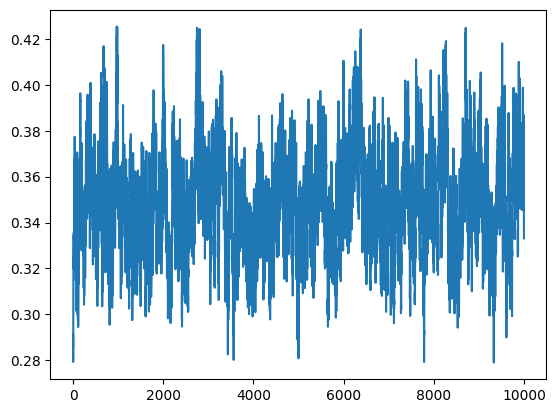

In [139]:
plt.plot(range(len(avg_fit)), avg_fit)

## V2.0

In [ ]:
N_ISLANDS = 5           # Number of different populations
POP_SIZE = 100          # Number of parents
N_OFFSPRINGS = 300      # Number of children
N_GENERATIONS = 10000   # Number of generations
TOP_K = 30              # Number of parents from which generating the offsprings
EPOCH = 50              # Number of generation to reintroduce the best fitting.

globe = {f'island{k}' : [] for k in range(N_ISLANDS)}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        globe[f'island{n}'].append(choices([0, 1], k=30))
        
italy = globe['island0']

In [ ]:
def mutate_bits(individual : list) -> list:
    '''
    Mutate every bit with a given probability
    '''
    # TODO
    idx = np.random.randint(0, len(individual), size = len(individual))
    mutated_individual = copy.deepcopy(individual)
    np.random.random(size = len(individual))
    if np.random.random() < 0.9:
        mutated_individual[idx] = int(not(bool(mutated_individual[idx])))
    return mutated_individual
